In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DataMining-Assignments
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DataMining-Assignments
'Air quality'/   open-plaques-United-Kingdom-2018-04-09.csv
 Covid/          README.gdoc


In [ ]:
!pip install geopandas
!pip install contextily

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import geopandas as gp
import contextily as ctx

##Data Exploration
-----------------

The dataset is basically a documentation of the historical link between certain people and places in the UK, which is recorded by putting up of plaques. The dataset used for this assignment is the openly available as BluePlaquesUK dataset [http://openplaques.org/pages/data](http://openplaques.org/pages/data) on the openplaques website. [http://openplaques.org/](http://openplaques.org/). A blue plaque is a permanent sign installed in a public place in the United Kingdom and elsewhere to commemorate a link between that location and a famous person, event, or former building on the site, serving as a historical marker.

In [ ]:
data = pd.read_csv("open-plaques-United-Kingdom-2018-04-09.csv")
data.head()

,id,machine_tag,title,inscription,latitude,longitude,as_wkt,country,area,address,erected,main_photo,colour,organisations,language,series,series_ref,geolocated?,photographed?,number_of_subjects,number_of_male_subjects,number_of_female_subjects,number_of_inanimate_subjects,lead_subject_id,lead_subject_machine_tag,lead_subject_name,lead_subject_surname,lead_subject_sex,lead_subject_born_in,lead_subject_died_in,lead_subject_type,lead_subject_roles,lead_subject_primary_role,lead_subject_wikipedia,lead_subject_dbpedia,lead_subject_image,subjects
0,41936,openplaques:id=41936,Abbotskerswell Cottage Art School and John Phi...,Abbotskerswell Cottage Art School was founded ...,50.51017,-3.61166,POINT(-3.61166 50.51017),United Kingdom,Abbotskerswell,NaN,NaN,http://s0.geograph.org.uk/geophotos/01/61/45/1...,black,"[""Torquay Pottery Collectors Society""]",English,NaN,NaN,True,True,2,2,0,1,18894.0,openplaques:subject:id=18894,Abbotskerswell Cottage Art School,Art School,object,1883.0,NaN,group,"[""art school""]",art school,NaN,NaN,NaN,"[""Abbotskerswell Cottage Art School|(1883-pres..."
1,4856,openplaques:id=4856,Arthur Linton blue plaque,World Champion Cyclist 1895 lived here Arthur ...,51.70050,-3.42510,POINT(-3.4251 51.7005),United Kingdom,Aberaman,"Sheppard's Pharmacy, 218 Cardiff Road",2009.0,NaN,blue,"[""Rhondda Cynon Taf Council""]",English,NaN,NaN,True,False,1,1,0,0,2934.0,openplaques:subject:id=2934,Arthur Linton,Linton,male,1868.0,1896.0,man,"[""World Champion Cyclist""]",World Champion Cyclist,https://en.wikipedia.org/wiki/Arthur_Linton,http://dbpedia.org/resource/Arthur_Linton,https://commons.wikimedia.org/wiki/Special:Fil...,"[""Arthur Linton|(1868-1896)|man|World Champion..."
2,30088,openplaques:id=30088,Alfred Johnson slate plaque,Alfred 'Centennial' Johnson. First single hand...,51.95974,-5.12763,POINT(-5.12763 51.95974),United Kingdom,Abercastle,quay wall,NaN,http://s0.geograph.org.uk/photos/91/72/917240_...,slate,[],English,NaN,NaN,True,True,1,1,0,0,9451.0,openplaques:subject:id=9451,Alfred Johnson,Johnson,male,1846.0,1927.0,man,"[""first single handed west to east Atlantic in...",first single handed west to east Atlantic in a...,"https://en.wikipedia.org/wiki/Alfred_""Centenni...","http://dbpedia.org/resource/Alfred_""Centennial...",NaN,"[""Alfred Johnson|(1846-1927)|man|first single ..."
3,1729,openplaques:id=1729,Navigation House blue plaque,Navigation House,51.63980,-3.33414,POINT(-3.33414 51.6398),United Kingdom,Abercynon,Cardiff Road,2009.0,NaN,blue,"[""Rhondda Cynon Taf Council""]",English,NaN,NaN,True,False,1,1,0,1,5559.0,openplaques:subject:id=5559,Navigation House,Navigation House,object,NaN,NaN,place,"[""house""]",house,NaN,NaN,NaN,"[""Navigation House||place|house""]"
4,43575,openplaques:id=43575,John Ewington blue plaque,Sefydlwyd y blaid lafur yn sgil streic Rheilff...,51.64407,-3.32798,POINT(-3.32798 51.64407),United Kingdom,Abercynon,Abercynon Railway Station,2015.0,https://farm5.staticflickr.com/4314/3586827949...,blue,"[""Rhondda Cynon Taf Council""]",Welsh & English,NaN,NaN,True,True,1,1,0,0,19814.0,openplaques:subject:id=19814,John Ewington,Ewington,male,NaN,NaN,man,[],NaN,https://en.wikipedia.org/wiki/John_Ewington,http://dbpedia.org/resource/John_Ewington,NaN,"[""John Ewington||man|""]"


We retain only the following columns for our purposes:

$\texttt{latitude, longitude, as_wkt, country, area, colour, language, lead_subject_born_in, lead_subject_died_in, lead_subject_type, lead_subject_sex}$

There are $28$ unique colours, have been encoded $0-27$ in the order: 'black', 'blue', 'slate', 'film cell', 'yellow', 'bronze', 'brown',
       'white', 'red', 'stone', 'grey', 'green', nan, 'multicoloured',
       'brushed metal', 'brass', 'gold', 'wood', 'clear', 'marble',
       'maroon', 'red and black', 'claret', 'purple',
       'purple, white and green', 'orange', 'green and red',
       'Belgian Blue Stone', 'terracotta'.

There are $1405$ unique areas.

There are $9$ different languages, encoded as $0-8$ in alphabetical order: 'English', 'Welsh & English', 'Welsh', 'Irish & English', nan,
       'Irish', 'Spanish', 'Latin', 'French', 'French & English'

There are $7$ lead subject types numberred $0-6$, with the order corresponding to 'group', 'man', 'place', 'thing', nan, 'woman', 'animal' in alphabetical order

There are $4$ different sexes numbered $0-3$ in alphabetical order: 'object', 'male', nan, 'female'

In [ ]:
from sklearn.preprocessing import LabelEncoder

data['area_encoded'] = LabelEncoder().fit_transform(data['area'].astype('str'))
data['type_encoded'] = LabelEncoder().fit_transform(data['lead_subject_type'].astype('str'))
data['sex_encoded'] = LabelEncoder().fit_transform(data['lead_subject_sex'].astype('str'))
data['language_encoded'] = LabelEncoder().fit_transform(data['language'].astype('str'))
data['colour_encoded'] = LabelEncoder().fit_transform(data['colour'].astype('str'))
data['country_encoded'] = LabelEncoder().fit_transform(data['country'].astype('str'))

# we won't be able to use the age attribute. if we remove NaN values, we end up with 6500 or so data items only. however, i'm still keeping it.

In [ ]:
usable_data = data.filter(['latitude', 'longitude', 'as_wkt', 'area_encoded', 'colour_encoded', 'language_encoded', 'type_encoded', 'sex_encoded'], axis=1)
usable_data = usable_data.dropna().reset_index(drop=True)
usable_data.head()

,latitude,longitude,as_wkt,area_encoded,colour_encoded,language_encoded,type_encoded,sex_encoded
0,50.51017,-3.61166,POINT(-3.61166 50.51017),0,1,0,1,3
1,51.70050,-3.42510,POINT(-3.4251 51.7005),1,2,0,2,1
2,51.95974,-5.12763,POINT(-5.12763 51.95974),2,23,0,2,1
3,51.63980,-3.33414,POINT(-3.33414 51.6398),3,2,0,4,3
4,51.64407,-3.32798,POINT(-3.32798 51.64407),3,2,8,2,1


Text(0, 0.5, 'colour')

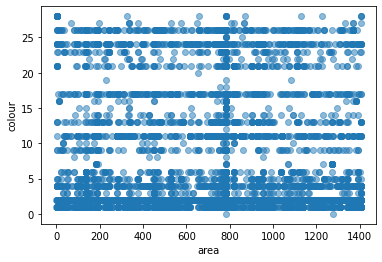

In [ ]:
# Extracting a sample dataframe of 2 dimensions
df1 = usable_data.filter(['area_encoded', 'colour_encoded'])
plt.scatter(np.array(df1)[:,0], np.array(df1)[:,1], alpha=0.5)
plt.xlabel("area")
plt.ylabel("colour")

It is quite clear from the preliminary exploration of each of the two dimensional sub-datasets that the data is already significantly clustered around some values/ ranges of values. We want our algorithm to be able to identify these clusters and label them.



[Algorithm] 

1.   Declare k, the number of clusters.
2.   We initialize k random point as centroids(cluster centers) within the data range.
3.   We assign each data point to a cluster with the minimum distance from the centroid. Here, we make use of Euclidean Distance.
4. We initialize new centroids for each cluster, as the average of the points of that particular cluster.
5. We do 3 & 4 iteralively enough times, such that the centroids stop changing.



# Clustering Helper Functions

In [ ]:
def min_distance(x, y, centroids):
  distances = np.zeros(len(centroids))
  for idx, center in enumerate(centroids):
    distances[idx] = np.sqrt((x - center[0])**2 + (y - center[1])**2)
  
  return np.argmin(distances) # index of the closest centroid in the centroids array


def assign(item, centroids):
  x, y = int(item[0]), int(item[1])
  closest = min_distance(x, y, centroids)
  return closest


def new_centroids(data, centroids):  
  d = pd.DataFrame(data)
  new_centroids = []
  for i, c in enumerate(centroids):
    collector = d[d[2]==i] #collects all rows with one kind of center
    new_x = np.nanmean(np.array(collector[0])) #x-coord
    new_y = np.nanmean(np.array(collector[1])) #y-coord
    new_centroids.append([new_x, new_y])

  return np.array(new_centroids)
 
def plot_state(data, centroids):
  ax = plt.subplot()
  d = pd.DataFrame(data)
  for i,_ in enumerate(centroids):
    collector = d[d[2]==i]
    ax.scatter(collector[0], collector[1], c = "C"+str(i+8))
    ax.scatter(centroids[i][0], centroids[i][1], c = "black", marker='X')
  return ax

def map_plot(d):
  df = usable_data.filter(['latitude', 'longitude'])
  dat = pd.DataFrame(d)
  df = df.join(dat[2]).rename(columns={2:"centroid"}, inplace=False)

  gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.longitude, df.latitude), crs=4326)
  #print(gdf.head())


  df_ = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
  df_ = df_.to_crs(epsg=4326)
  ax = df_[df_.name == 'United Kingdom'].plot(figsize=(30, 20), alpha=0.5, edgecolor='k')
  ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
  ax.set_axis_off()

  # We can now plot our ``GeoDataFrame``.

  gdf['centroid'] = gdf.groupby(['centroid']).ngroup()
  gdf.plot(ax = ax, column='centroid', categorical=True, legend=True, cmap="Blues")




# Clustering Algorithm

In [ ]:
# filter1 should have greater range than filter2
def cluster_plot(filter1, filter2, k=6, iter=6):
  df = usable_data.filter([filter1, filter2])
  max = np.amax(np.array(df), axis=0)
  scale_factor = max[0]/max[1]
  # Scaling such that the two axes have the same range
  df[filter2] *= scale_factor

  # step one: set k and initialize random cluster centers within the data range
  data = np.array(df)
  new_col = np.zeros(data.shape[0])
  data = np.insert(data, 2, new_col, axis=1)
  centroids = []

  for i in range(k):
    x = random.randint(0, np.amax(max))
    y = random.randint(0, np.amax(max))
    centroids.append([x,y])

  centroids = np.array(centroids)
  #print(centroids)

  # step two: (iterative) assign every point in the dataset to the closest cluster center and calculate the average within each cluster to assign new centers of the respective clusters
  i = 0
  while i < iter:
    for idx,item in enumerate(data):
      data[idx][2] = assign(item, centroids) #the third column stores the index of the center in the centroids array
    
    ax = plot_state(data, centroids)
    plt.xlabel(filter1[:-8])
    plt.ylabel(filter2[:-8])
    plt.show()
  
    centroids = new_centroids(data, centroids)
    #print(centroids)
    i=i+1

  return data

# Area v/s Plaque Colour

The first section below shows the clustering algorithm at work demarcating the set k clusters with the 2 dimensions in question being the colour of  the plaque and the area the plaque is located in. 

In the second section, we have mapped the points onto a map of the UK and the colors in the map legend simply represent which cluster the plaque belongs to.


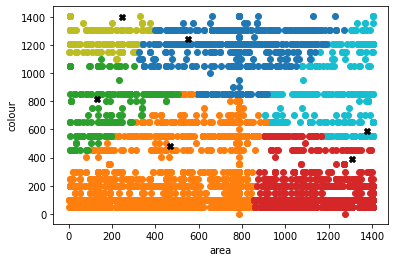

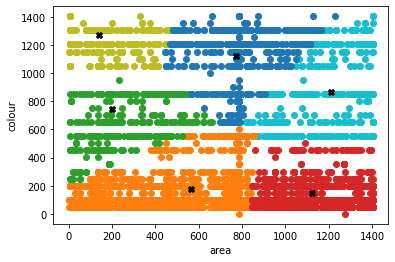

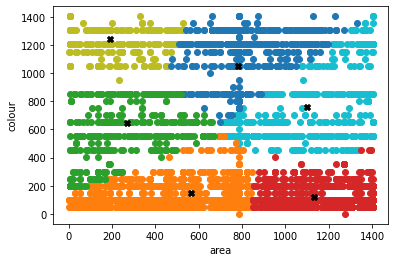

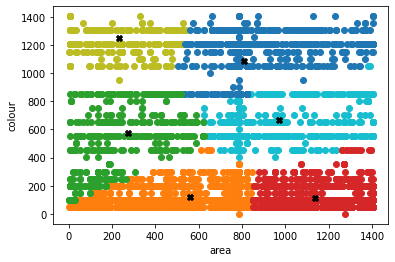

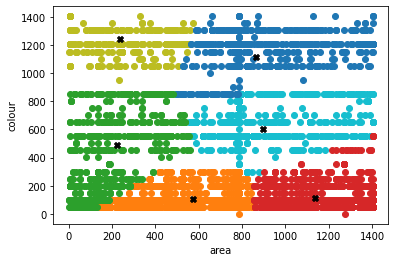

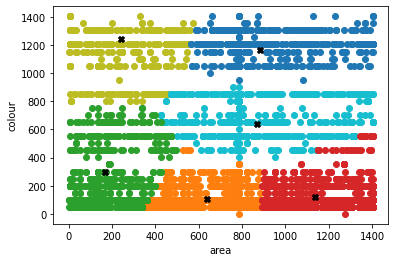

In [ ]:
d = cluster_plot('area_encoded', 'colour_encoded')

/usr/local/lib/python3.7/dist-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


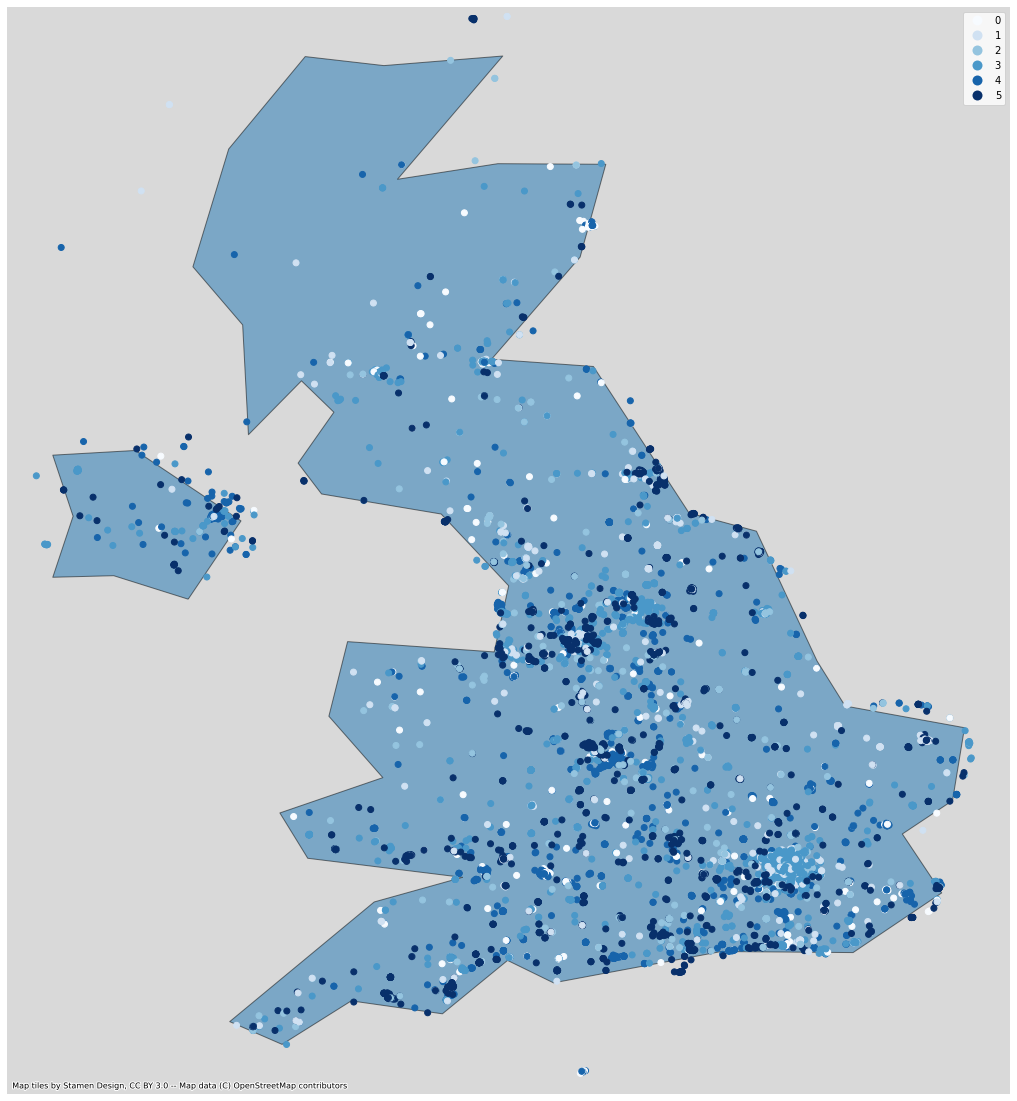

In [ ]:
map_plot(d)

# Area v/s Plaque Type

The first section below shows the clustering algorithm at work demarcating the set k clusters with the 2 dimensions in question being the type of plaque and the area the plaque was in. 

In the second section, the colors in the map legend simply represent which cluster the plaque belongs to.

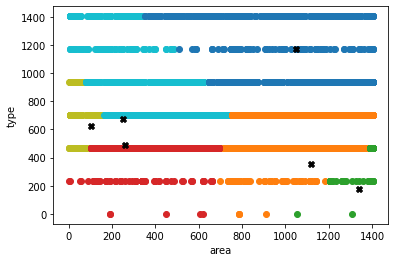

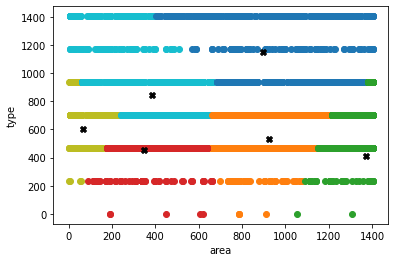

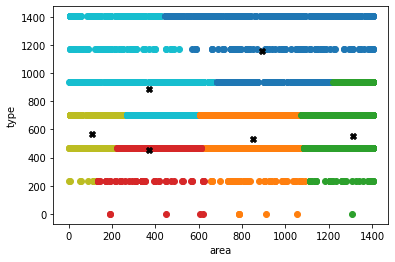

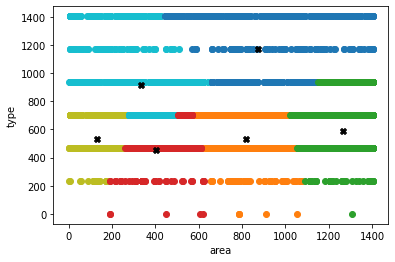

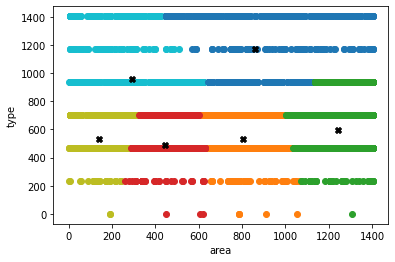

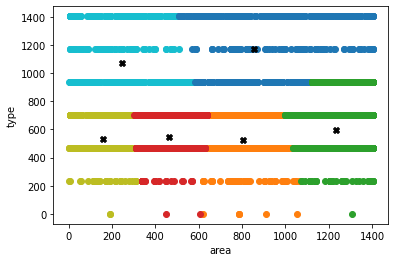

In [ ]:
d2= cluster_plot('area_encoded', 'type_encoded')

/usr/local/lib/python3.7/dist-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


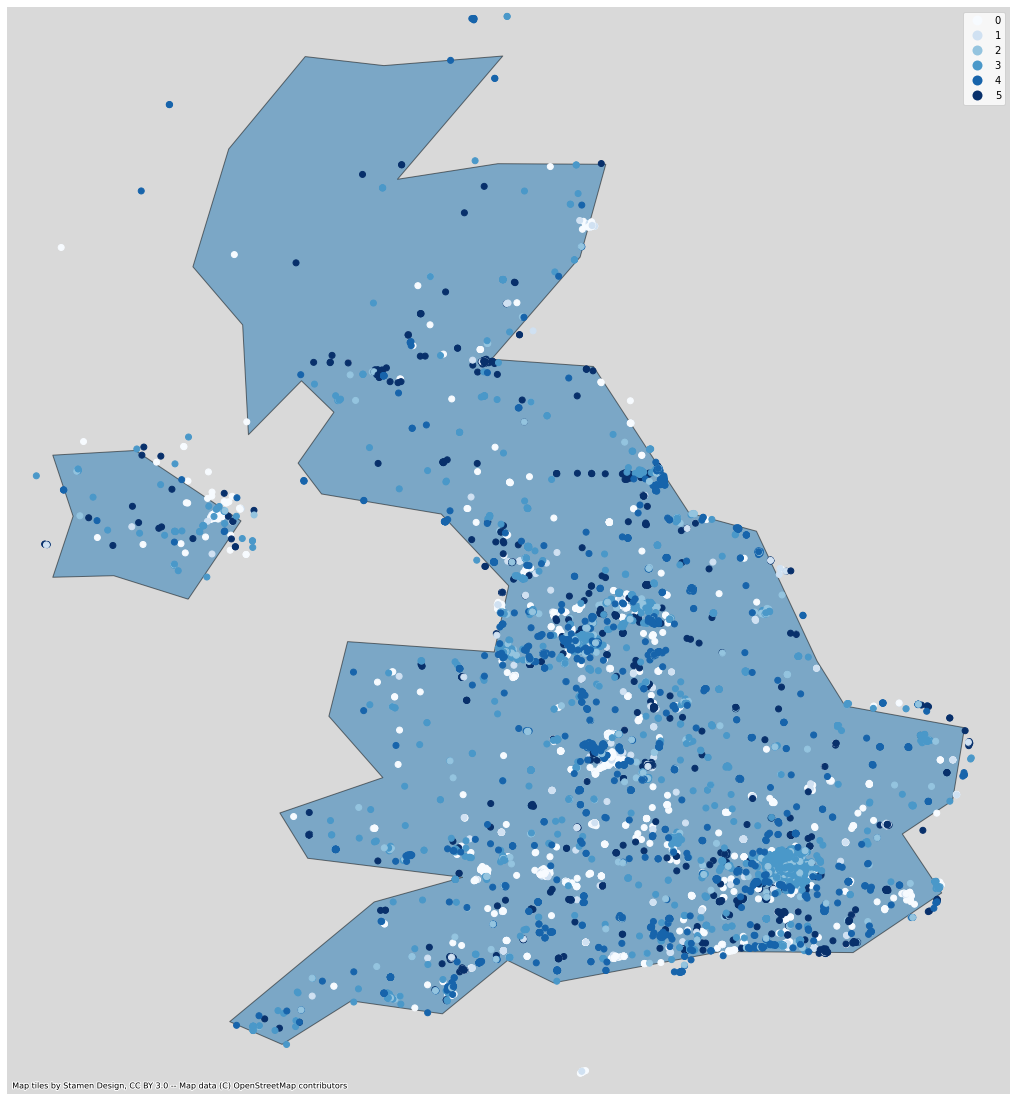

In [ ]:
map_plot(d2)

# Plaque colour vs Sex of person commemorated

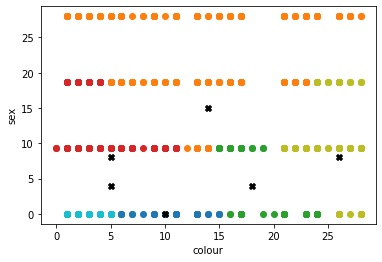

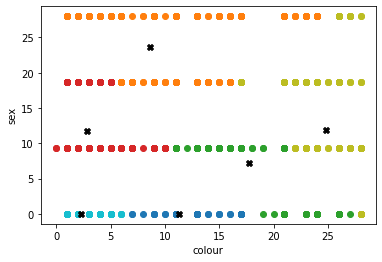

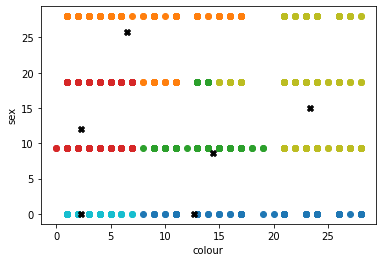

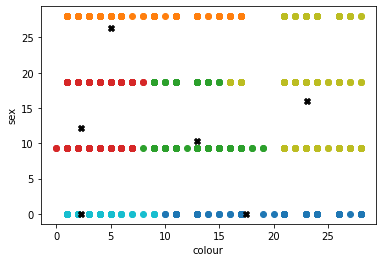

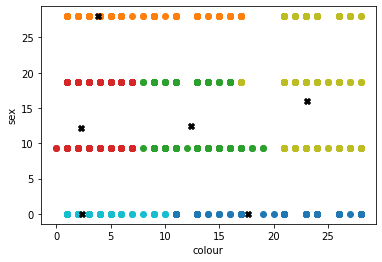

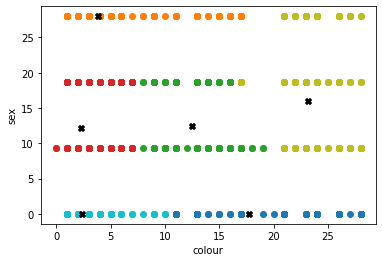

In [ ]:
d3 = cluster_plot('colour_encoded', 'sex_encoded')

/usr/local/lib/python3.7/dist-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


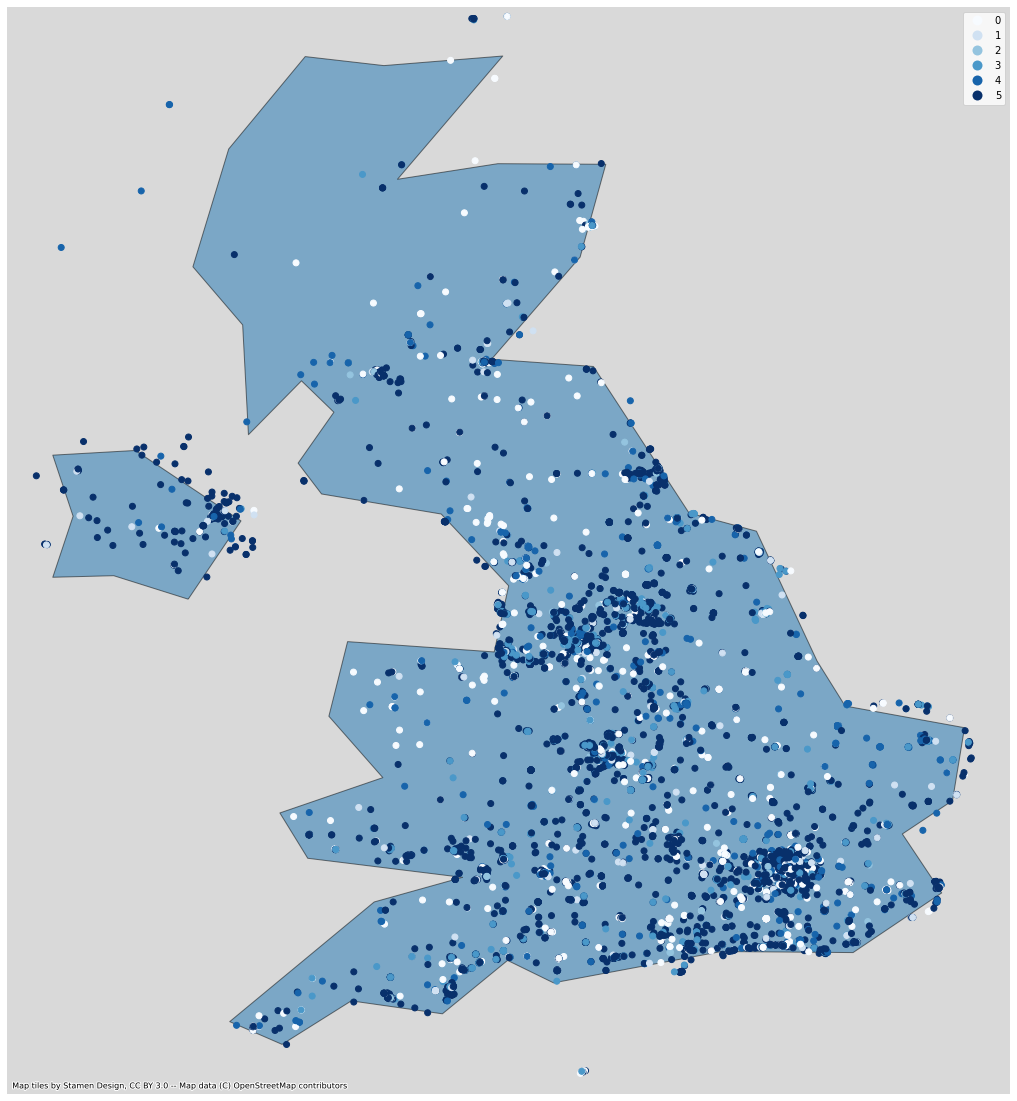

In [ ]:
map_plot(d3)

##Observations:
--------------
We faced 2 problems while implementing the clustering algorithm: 

1. As several columns of the data consist of strings and not numbers (we need numeric values for clustering),  we had to assign a number to each distinct string. This led to some sort of false ordering which affected how our clusters were formed and which points ended up in one cluster.
2. Initially, all the clusters printed out to be somewhat horizontal (or vertical) instead of being circular. The reason for this was the non-uniform scaling of the two axes. While encoding, one variable ranged from say 0-1405 while the other was from say 0-27. The axes had different ranges and hence the clusters were stretched horizontally (or vertically). We solved this problem by multiplying the axis (with a smaller range) with a scale factor. This made the ranges of both the axes equal and
we started getting circular clusters.


While we haven't shown what the data looks like when clustered with higher or lower values of $k$, we have tried different values for it, and you can test it out with any value by changing the value taken as parameter to the $\texttt{cluster_plot}$ function. We observed that the centroids stabilised after around 10 iterations in every set, so we didn't need to add more iterations. However, yo ucan also tweak that in the function parameters. We are currently unable to derive useful information from the plots, but hope to be able to make sense of it after having gone through this course.